In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.model_selection import train_test_split

2024-07-13 20:10:37.423025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 20:10:37.423224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 20:10:37.614164: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
print("TensorFlow v" + tf.__version__)
print("SciKit Learn v" + skl.__version__)

TensorFlow v2.15.0
SciKit Learn v1.2.2


In [4]:
house_prices_training_path = '../input/house-prices-advanced-regression-techniques/train.csv'
training_df = pd.read_csv(house_prices_training_path)
training_df.shape

(1460, 81)

In [5]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
training_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


(array([ 16.,  74., 184., 345., 252., 199., 125.,  85.,  61.,  38.,  27.,
         15.,  14.,   8.,   6.,   2.,   1.,   1.,   2.,   1.,   2.,   0.,
          0.,   0.,   2.]),
 array([ 34900.,  63704.,  92508., 121312., 150116., 178920., 207724.,
        236528., 265332., 294136., 322940., 351744., 380548., 409352.,
        438156., 466960., 495764., 524568., 553372., 582176., 610980.,
        639784., 668588., 697392., 726196., 755000.]),
 <BarContainer object of 25 artists>)

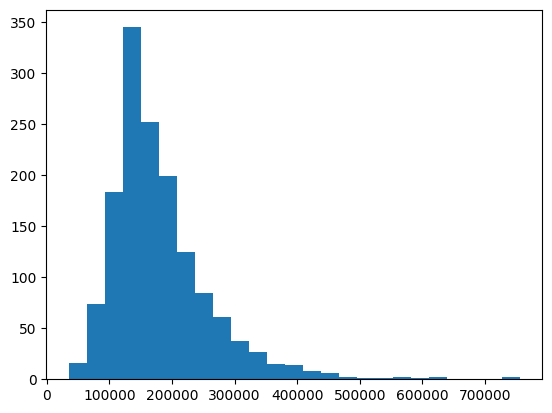

In [7]:
print(training_df.SalePrice.describe())
plt.hist(training_df.SalePrice, bins = 25)

In [8]:
df_num = training_df.select_dtypes(include = ['int64','float64'])
df_num.head(3)
print(df_num.shape) #This will have fewer columns as we are dropping categorical variables from training_df
print(training_df.shape) 

(1460, 38)
(1460, 81)


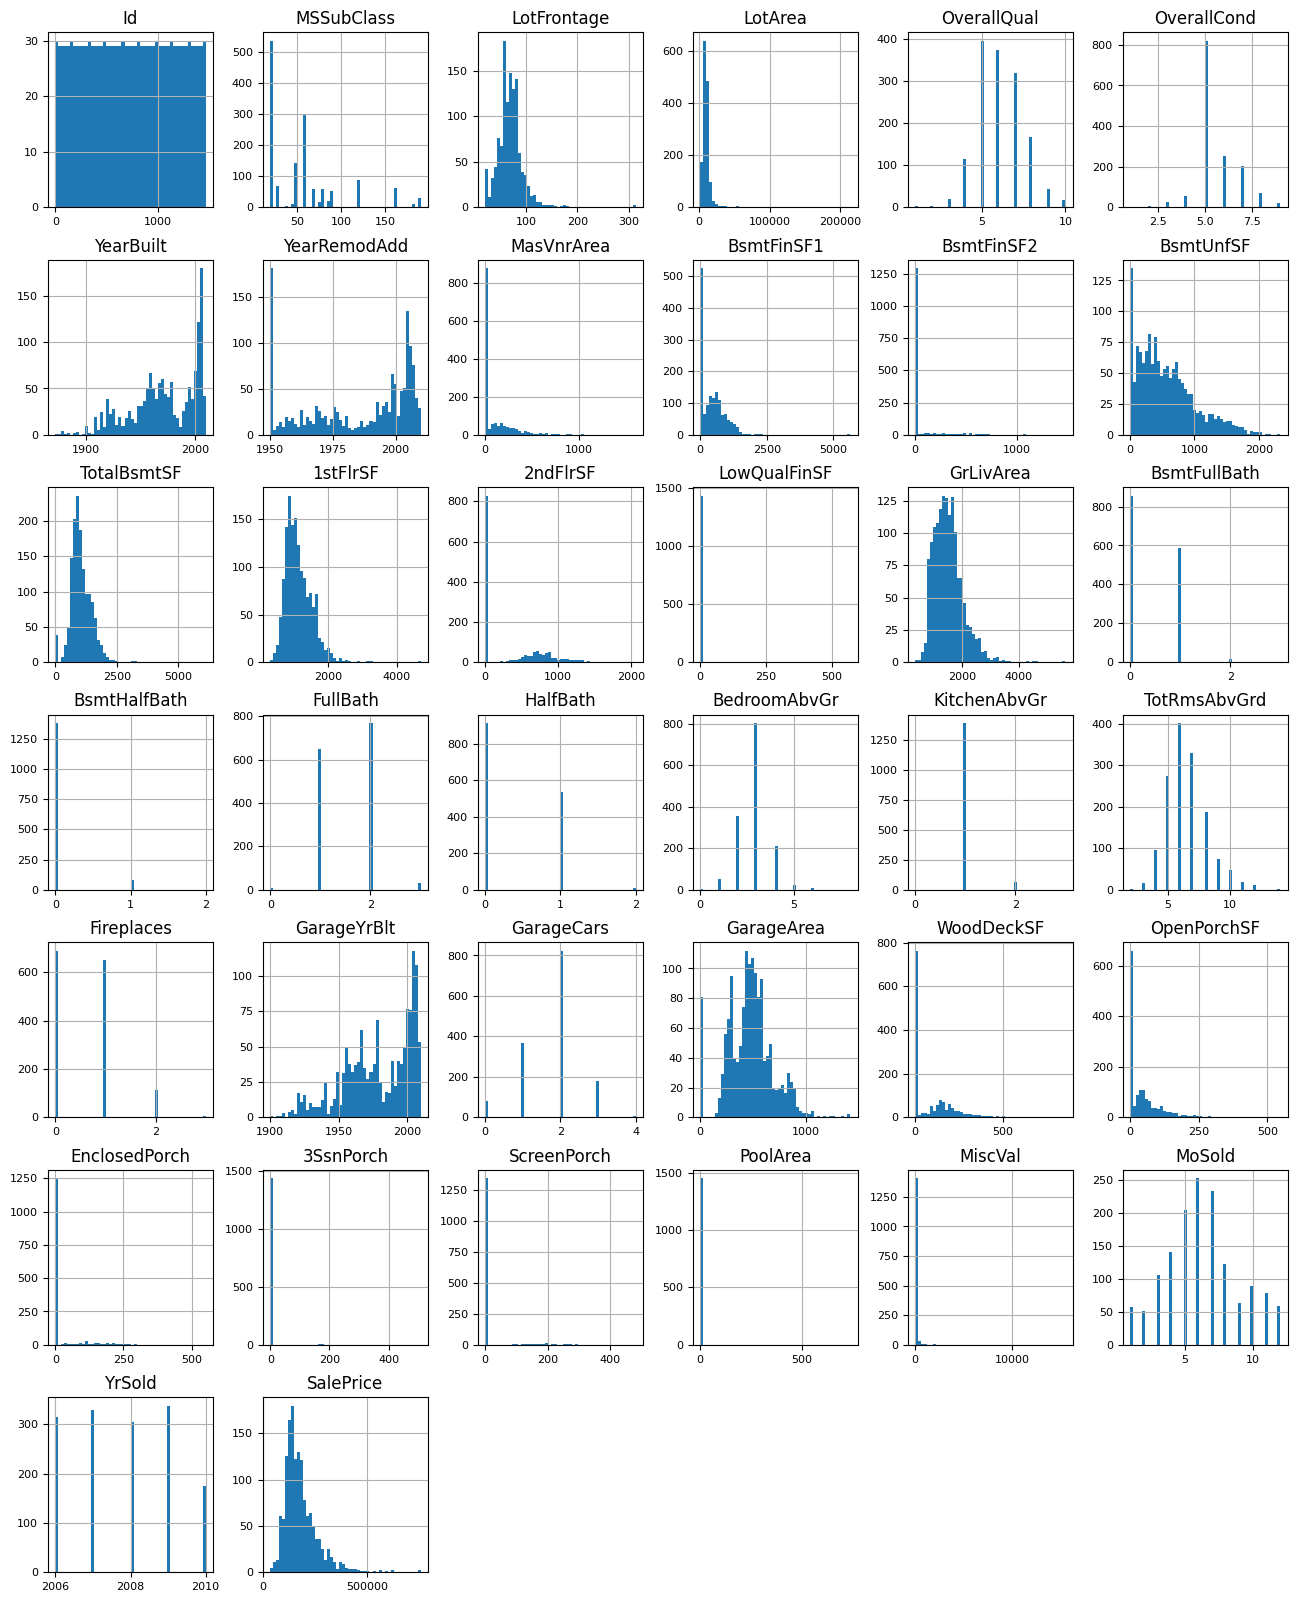

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [10]:
corr_matrix = df_num.corr()

corr_matrix["SalePrice"].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

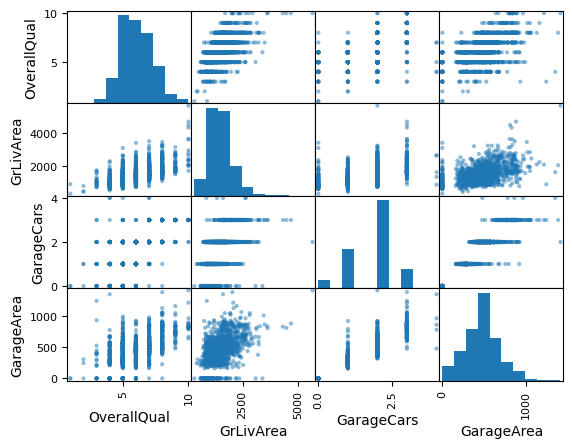

In [11]:
from pandas.plotting import scatter_matrix

attributes1 = ["OverallQual","GrLivArea","GarageCars","GarageArea"]
attributes2 = ["TotalBsmtSF","1stFlrSF","FullBath","TotRmsAbvGrd"]
attributes3 = ["YearBuilt","YearRemodAdd","GarageYrBlt","MasVnrArea"]
attributes4 = ["Fireplaces","BsmtFinSF1","LotFrontage","WoodDeckSF"]

scatter_matrix(df_num[attributes1])
plt.show()

In [12]:
train_data_df, test_data_df = train_test_split(training_df, test_size = 0.3, random_state = 1)
print("{} examples in full dataset, {} examples in training data, and {} examples in test data".format(len(training_df),len(train_data_df), len(test_data_df)))

1460 examples in full dataset, 1022 examples in training data, and 438 examples in test data


In [13]:
print(test_data_df.shape, train_data_df.shape)

(438, 81) (1022, 81)


In [14]:
#Goal is to use Tensorflow DecisionForests to predict house prices.
#By default, TFDF is configured for classification problems. We will specify task = tfdf.keras.Task.REGRESSION to configure for regression

#Convert Pandas Dataframe to Tensorflow Dataset
label = "SalePrice"
train_data_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data_df, label = label, task = tfdf.keras.Task.REGRESSION)
test_data_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data_df, label = label, task = tfdf.keras.Task.REGRESSION)

In [15]:
#TFDF can use a variety of models, but we're going to use a random forest to start off.
#Code below is to identify all models within the TensorFlow Decision Forests package

tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [16]:
# Goal is to create a RandomForest model using TensorFlow specified defaults.
# Remember - task needs to be set to regression, as Decision Forests are configured for classification problems by default.
# Mean Squared Error will be our accuracy measure

rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics = ["mse"])

rf.fit(x = train_data_ds)

Use /tmp/tmp19qg_vc_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.971163. Found 1022 examples.
Training model...


[INFO 24-07-13 20:11:20.4347 UTC kernel.cc:1233] Loading model from path /tmp/tmp19qg_vc_/model/ with prefix 49086761ba7c442c


Model trained in 0:00:02.195553
Compiling model...


[INFO 24-07-13 20:11:20.8759 UTC decision_forest.cc:660] Model loaded with 300 root(s), 97044 node(s), and 77 input feature(s).
[INFO 24-07-13 20:11:20.8760 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-07-13 20:11:20.8760 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [17]:
# Visualize a given tree
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx = 0, max_depth = 3)